## Neural Nets Implementation & XOR Problem

**Goal:** The goal of this exercise is to implement a small neural network from scratch and train it using backprop.

In [102]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid, train_test_split

In [87]:
# Load xor toy dataset
with open('../data/xordata.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train'] # 800 training data points with 2 features
y_train = data['y_train'] # training binary labels {0,1}

X_test = data['X_test']
y_test = data['y_test']

In [88]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 2) (800,)
(200, 2) (200,)


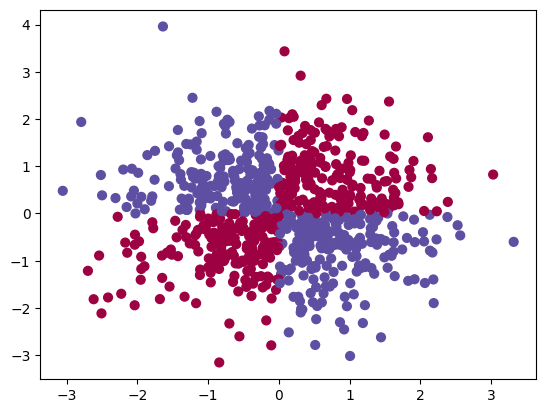

In [89]:
plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=plt.cm.Spectral)

**In this exercise, do the following:**
1. Implement brackprop to train a two-layer perceptron: an input layer, a hidden layer, and an output layer.
2. The core of the code should include: a forward pass, a backward pass, and weight updates.
3. For input and output layers specify the number of nodes appropriate for the above problem.
4. Randomly initialize the weights and biases of the network.
5. For the hidden layer use ReLU as an activation function and for the output layer use logistic sigmoid.
6. Use cross-entropy loss as the network's loss function and mini-batch SGD as the optimizer.
7. Use cross-validation to estimate performance.
8. Tune the network as you see fit (including number of units in the hidden layer, learning rate,  batch size, number of epochs, etc).
9. Provide a classification report of the performance on the train and test set.
10. Write a summary. Make sure you document your code well.
  
(Optional) You can use sklearn.inspection.DecisionBoundaryDisplay to visualize your decision boundary.

In [90]:
# two layer perceptron model class
class TwoLayerPerceptron(): 
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # initialize weights and biases randomly
        self.W1 = np.random.randn(self.input_size, self.hidden_size)
        self.b1 = np.random.randn(1, self.hidden_size)
        self.W2 = np.random.randn(self.hidden_size, self.output_size)
        self.b2 = np.random.randn(1, self.output_size)

        # initialize intermediate outputs
        self.a1 = None
        self.z1 = None
        self.a2 = None
        self.z2 = None

        # initialize backprop gradients
        self.dW1 = None
        self.db1 = None
        self.dW2 = None
        self.db2 = None
        
    def forward(self, X):
        # forward pass
        self.a1 = np.dot(X, self.W1) + self.b1
        self.z1 = np.maximum(0, self.a1) # ReLU activation
        self.a2 = np.dot(self.z1, self.W2) + self.b2
        self.z2 = 1 / (1 + np.exp(-self.a2)) # sigmoid activation
        return self.z2
    
    def backward(self, X, y, output):
        # backward pass
        # get batch size
        m = X.shape[0]
        
        y = y.reshape(-1, 1)

        # compute gradients for output layer (layer 2)
        dZ2 = output - y 
        self.dW2 = (1/m) * np.dot(self.z1.T, dZ2)
        self.db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)
        
        # compute gradients for hidden layer (layer 1)
        dZ1 = np.dot(dZ2, self.W2.T) * (self.a1 > 0) # ReLU derivative
        self.dW1 = (1/m) * np.dot(X.T, dZ1)
        self.db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)
        
    def update(self):
        # update weights and biases using gradient descent
        if self.dW1 is not None and self.db1 is not None and self.dW2 is not None and self.db2 is not None:
            self.W2 -= self.learning_rate * self.dW2
            self.b2 -= self.learning_rate * self.db2
            self.W1 -= self.learning_rate * self.dW1 
            self.b1 -= self.learning_rate * self.db1
        else:
            raise ValueError("Gradients are empty.")
        




In [112]:
# utility functions 
# binary cross entropy loss
def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# train loop 
def train(model, X_train, y_train, X_val, y_val, num_epochs=1000, batch_size=32):
    n_samples = X_train.shape[0]
    history = {'train_loss': [], 'val_loss': []}
    
    # mini-batch SGD
    for epoch in range(num_epochs):
        # get mini-batch indices
        batch_indices = np.random.permutation(n_samples)  
        X_shuffled = X_train[batch_indices, :]
        y_shuffled = y_train[batch_indices]
        for i in range(0, n_samples, batch_size):
            # get batch
            batch_end = min(i + batch_size, n_samples)
            X_batch = X_shuffled[i:batch_end, :]
            y_batch = y_shuffled[i:batch_end]

            # forward pass  
            output = model.forward(X_batch)

            # backward pass
            model.backward(X_batch, y_batch, output)

            # update weights and biases
            model.update()

        # compute loss
        train_loss = cross_entropy_loss(y_train.reshape(-1, 1), model.forward(X_train))
        val_loss = cross_entropy_loss(y_val.reshape(-1, 1), model.forward(X_val))
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

    return history

# cross validation
def cross_validation(model_class, X, y, n_splits=5, **params):
    # unpack params 
    hidden_size = params['hidden_size']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    num_epochs = params['num_epochs']

    # create kfold 
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    losses = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # create model and train
        model = model_class(input_size=2, hidden_size=hidden_size, output_size=1, learning_rate=learning_rate)

        history = train(model, X_train, y_train, X_val, y_val, num_epochs=num_epochs, batch_size=batch_size)
        losses.append(history['val_loss'][-1])

    return np.mean(losses)

# grid search cross validation
def grid_search_cv(model_class, X, y, param_grid, n_splits=5):
    param_combinations = list(ParameterGrid(param_grid))
    results = []
    best_loss = float('inf')
    best_params = None

    for params in param_combinations:
        loss = cross_validation(model_class, X, y, n_splits=n_splits, **params)
        print(f"Loss with params {params}: {loss}")
        results.append({'params': params, 'loss': loss})

        if loss < best_loss:
            best_loss = loss
            best_params = params

    return results, best_params

# plot loss history 
def plot_loss_history(history):
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

# plot predictions
def plot_predictions(model, X, y):
    y_pred = (model.forward(X) > 0.5).ravel()  

    plt.figure(figsize=(12, 5))

    # plot original data
    plt.subplot(1, 2, 1)
    plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
    plt.title('Original Data')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # plot predictions
    plt.subplot(1, 2, 2)
    plt.scatter(X[:,0], X[:,1], s=40, c=y_pred, cmap=plt.cm.Spectral)
    plt.title('Model Predictions')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    plt.tight_layout()
    plt.show()

# classification report 
def get_classification_report(model, X, y):
    y_pred = (model.forward(X) > 0.5).ravel()
    print("Classification Report:")
    print(classification_report(y, y_pred))



In [113]:
# grid search parameters
param_grid = {
    'hidden_size': [4, 8, 16, 32],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'num_epochs': [100, 1000, 2000, 3000]
}

all_results, best_params = grid_search_cv(TwoLayerPerceptron, X_train, y_train, param_grid)
print(f"Best Params: {best_params}")
print(f"All Results: {all_results}")

Loss with params {'batch_size': 16, 'hidden_size': 4, 'learning_rate': 0.001, 'num_epochs': 100}: 0.653708936871257
Loss with params {'batch_size': 16, 'hidden_size': 4, 'learning_rate': 0.001, 'num_epochs': 1000}: 0.3699643079602167
Loss with params {'batch_size': 16, 'hidden_size': 4, 'learning_rate': 0.001, 'num_epochs': 2000}: 0.40145531598842804
Loss with params {'batch_size': 16, 'hidden_size': 4, 'learning_rate': 0.001, 'num_epochs': 3000}: 0.208397407299932
Loss with params {'batch_size': 16, 'hidden_size': 4, 'learning_rate': 0.01, 'num_epochs': 100}: 0.3634255076817627
Loss with params {'batch_size': 16, 'hidden_size': 4, 'learning_rate': 0.01, 'num_epochs': 1000}: 0.10607850259398814
Loss with params {'batch_size': 16, 'hidden_size': 4, 'learning_rate': 0.01, 'num_epochs': 2000}: 0.06658467874585058
Loss with params {'batch_size': 16, 'hidden_size': 4, 'learning_rate': 0.01, 'num_epochs': 3000}: 0.05501929723081177
Loss with params {'batch_size': 16, 'hidden_size': 4, 'learn

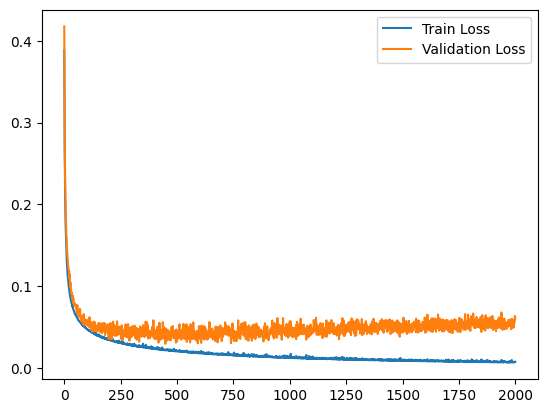

In [114]:
# unpack best parameters
input_size = 2 
hidden_size = best_params['hidden_size']
output_size = 1
learning_rate = best_params['learning_rate']
batch_size = best_params['batch_size']
num_epochs = best_params['num_epochs']

# train with best parameters
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = TwoLayerPerceptron(input_size, hidden_size, output_size, learning_rate)
history = train(model, X_train_split, y_train_split, X_val_split, y_val_split, num_epochs=num_epochs, batch_size=batch_size)

# examine loss history
plot_loss_history(history)

In [123]:
# final test loss on best model
print(best_params)
test_loss = cross_entropy_loss(y_test.reshape(-1, 1), model.forward(X_test))
print(f"Test Loss: {test_loss}")

{'batch_size': 16, 'hidden_size': 16, 'learning_rate': 0.1, 'num_epochs': 2000}
Test Loss: 0.0022571619760904695


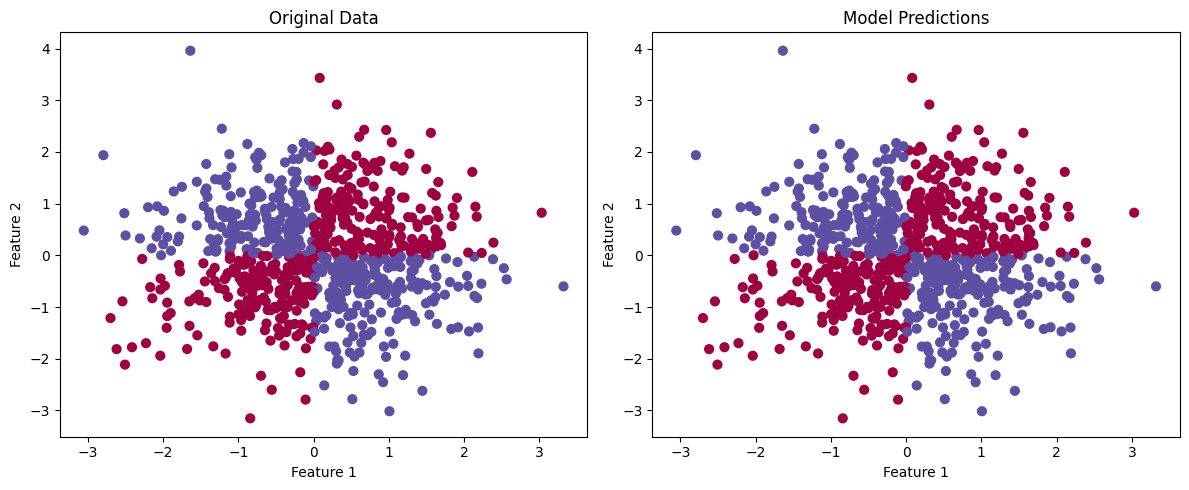

In [120]:
# checkout train predictions
plot_predictions(model, X_train, y_train)

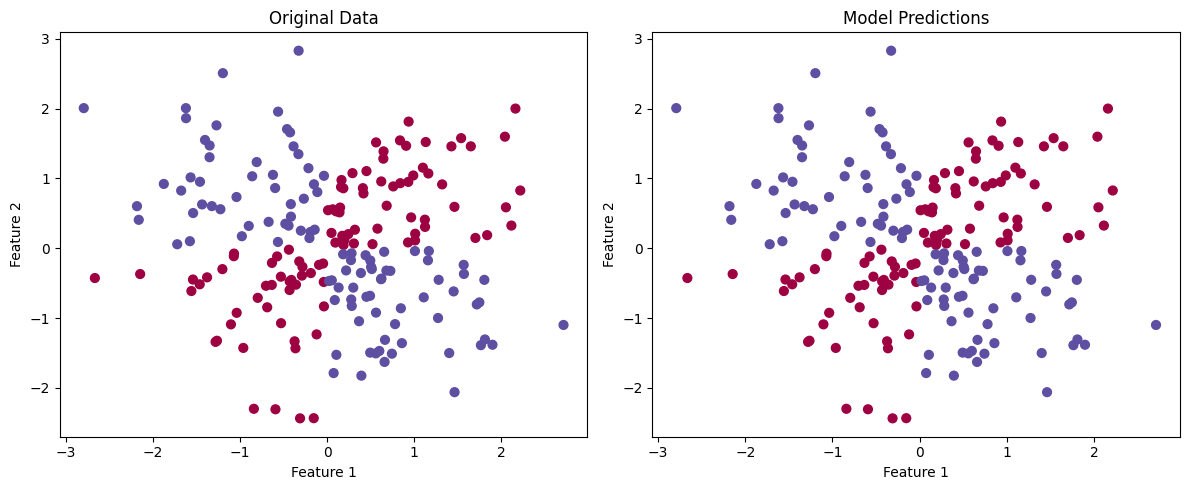

In [121]:
# checkout test predictions
plot_predictions(model, X_test, y_test)

In [122]:
# checkout test classification report
get_classification_report(model, X_test, y_test)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1       1.00      1.00      1.00       103

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



Summary: 
